## MP2: Red & White Wine

In [15]:
import pandas as pd, numpy as np, seaborn as sbn, matplotlib.pyplot as plt

from descriptive_stats import ct, dp, cr, vs
from utils.data_loader import load_excel, merge_wine_data, remove_missing, remove_duplicates

### Data Loading

In [17]:
xlsx_file_path = '../Data/winequality-red.xlsx'
df_red = load_excel(xlsx_file_path)

In [18]:
xlsx_file_path = '../Data/winequality-white.xlsx'
df_white = load_excel(xlsx_file_path)

In [19]:
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [20]:
df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [21]:
df_red.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [22]:
remove_missing(df_red)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [23]:
df_white.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [24]:
remove_missing(df_white)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [25]:
wine_df = merge_wine_data(df_red, df_white)

In [26]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


### Data Exploration

In [28]:
print("Red Wines:")
df_red.info()

print("\nWhite Wines:")
df_white.info()

print("\nCombined data:")
wine_df.info()

Red Wines:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  type                  1599 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB

White Wines:
<class 'pandas.core.frame.DataFrame'>


In [29]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 5.
Transform the categorical data into numeric, applying appropriate encoding methods.

In [31]:

wine_df['type'] = wine_df['type'].map({'red': 0, 'white': 1})

In [32]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


### 6.
Calculate the descriptive statistics of the numeric data. Check whether the distribution of
the values of the attributes is normal.

In [34]:
# Descriptive statistics - not sure if this is what is ment?
print(wine_df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

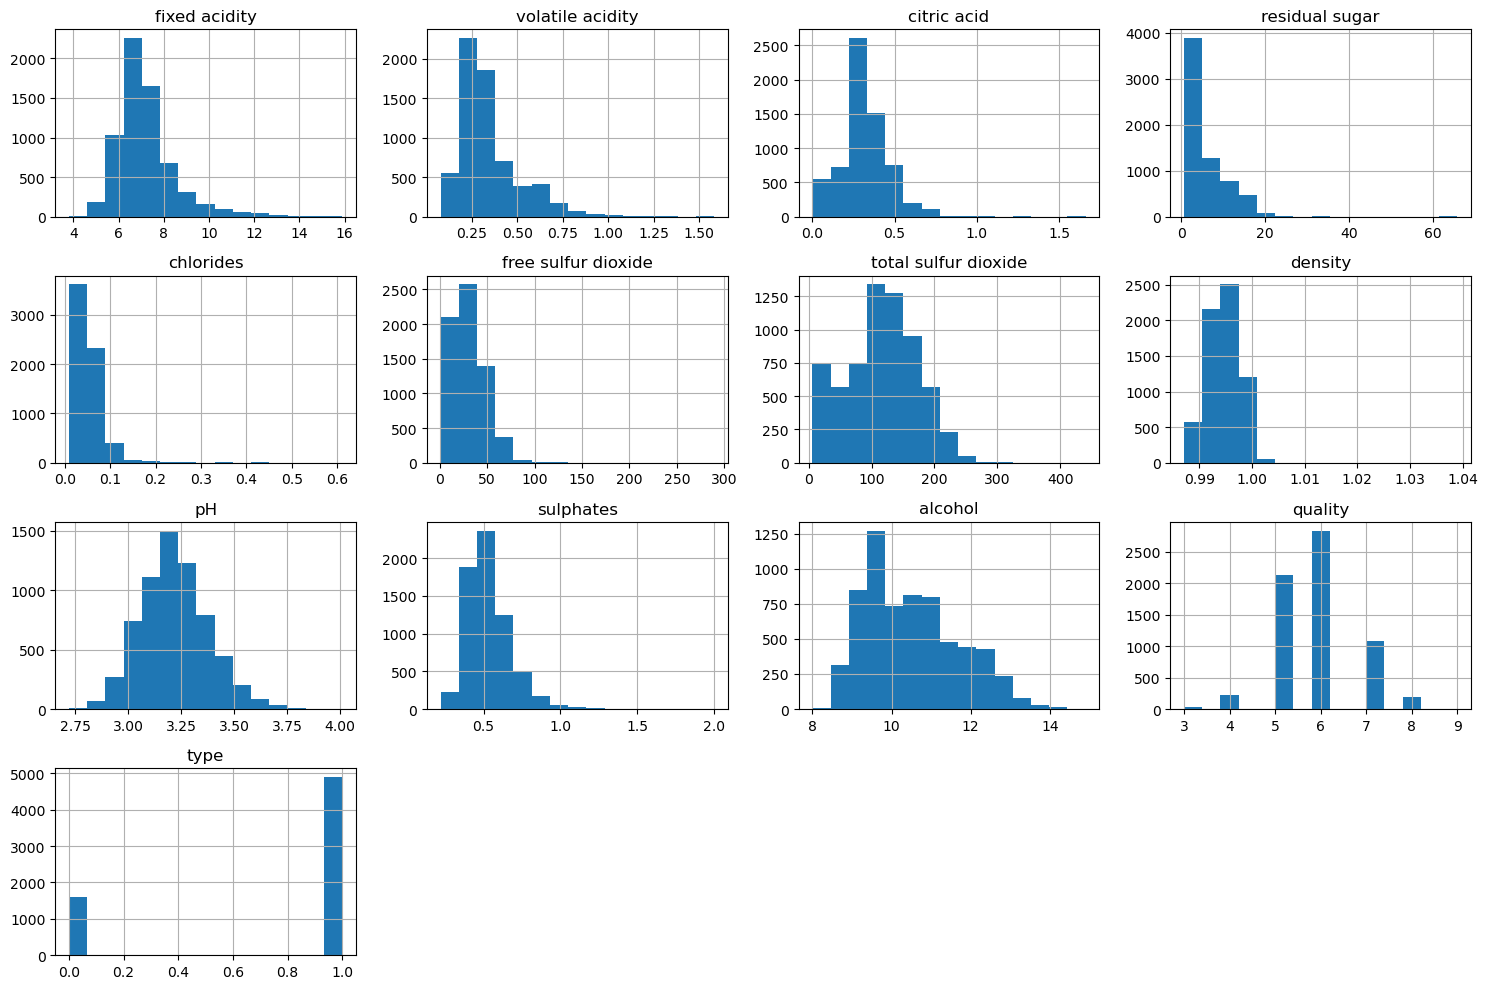

In [35]:
#smaller scale histogram
wine_df.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show() 

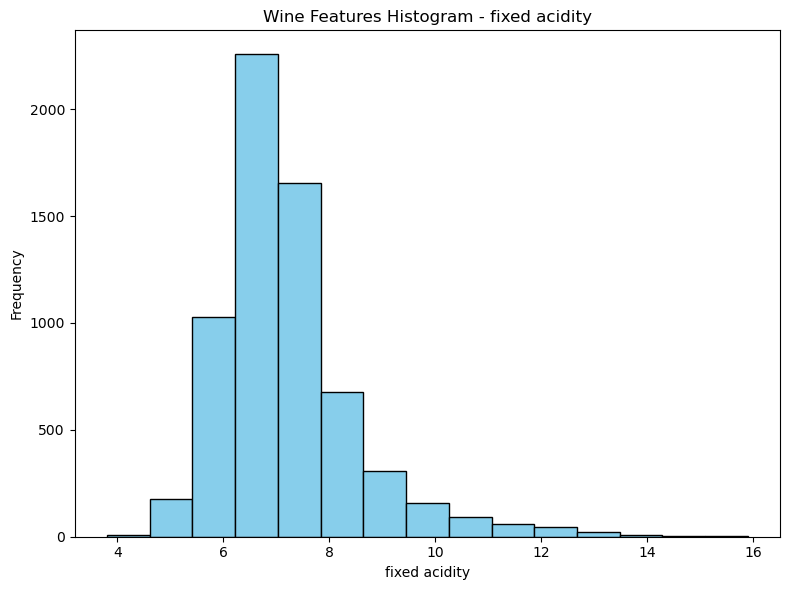

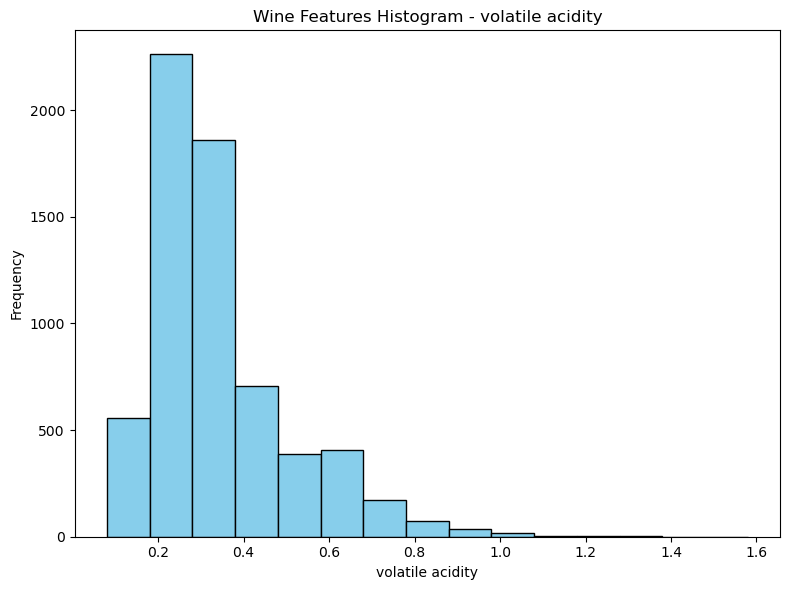

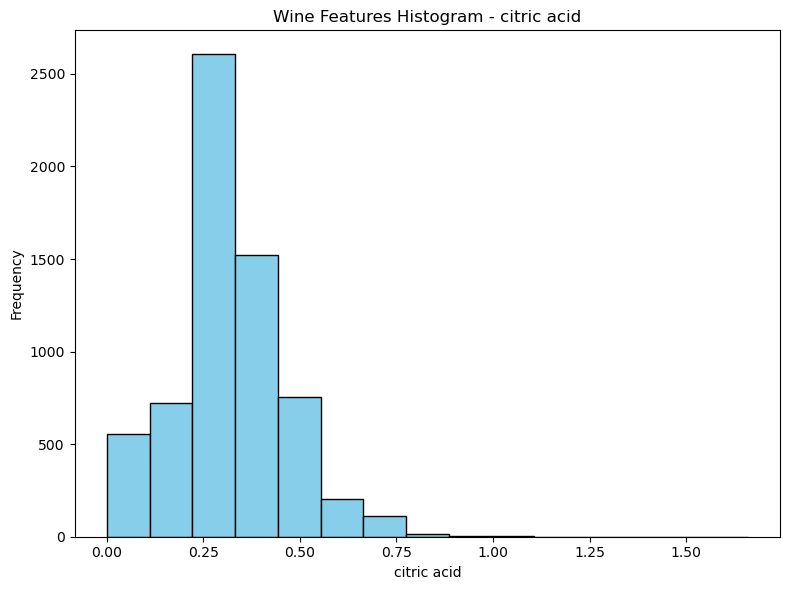

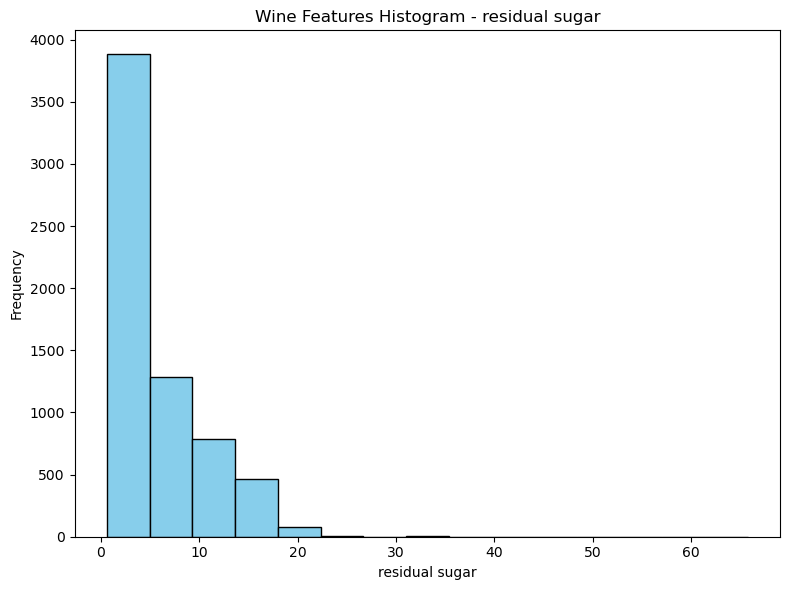

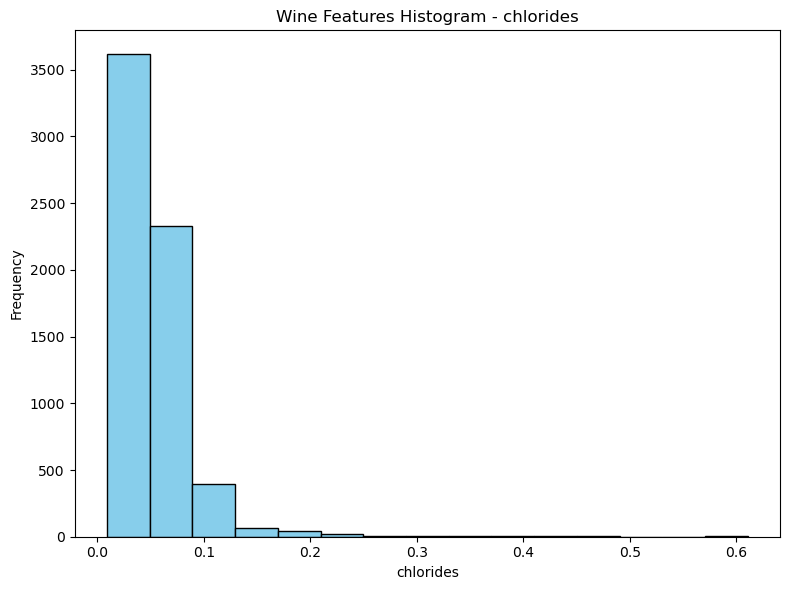

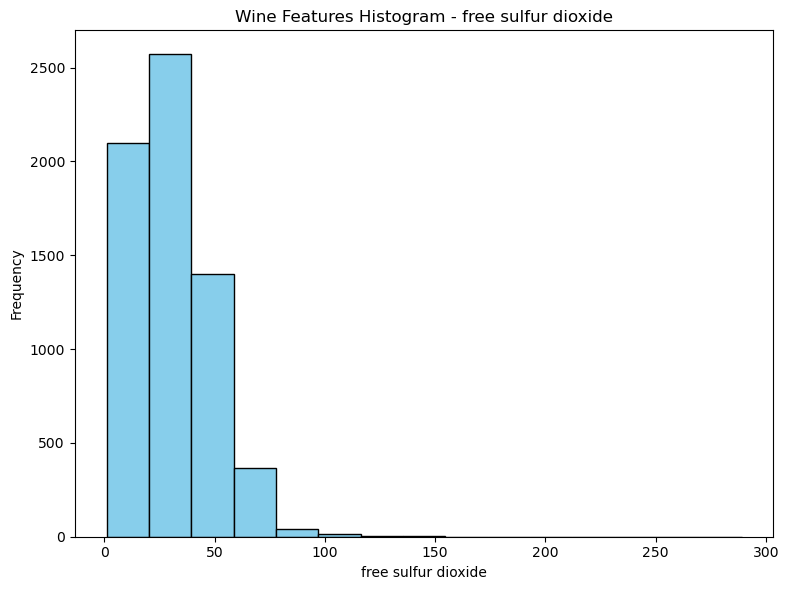

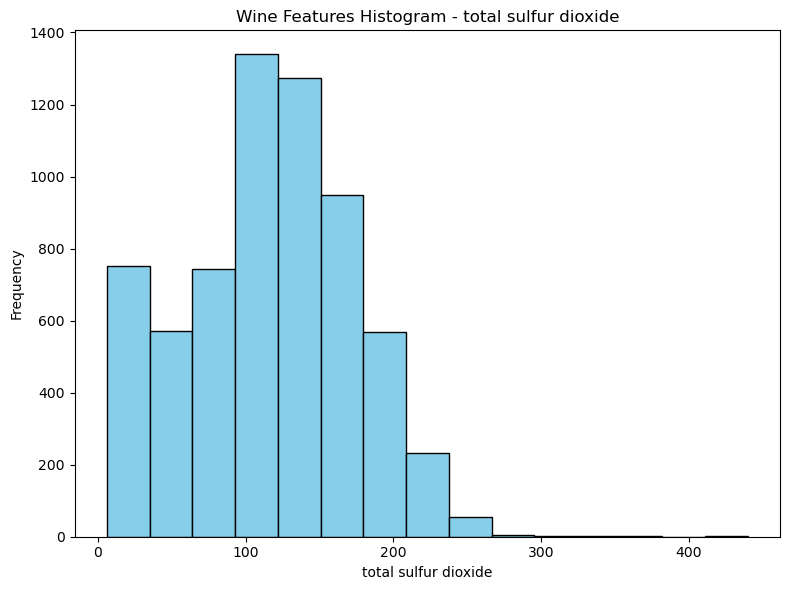

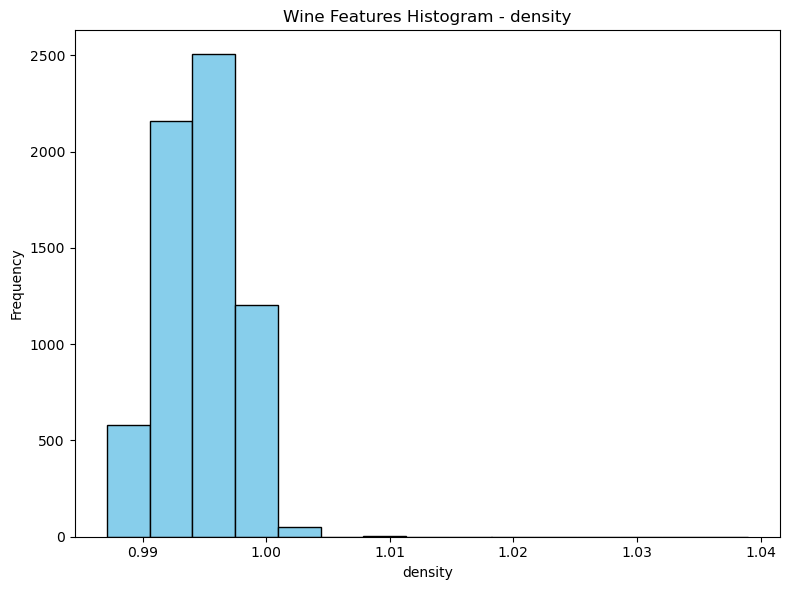

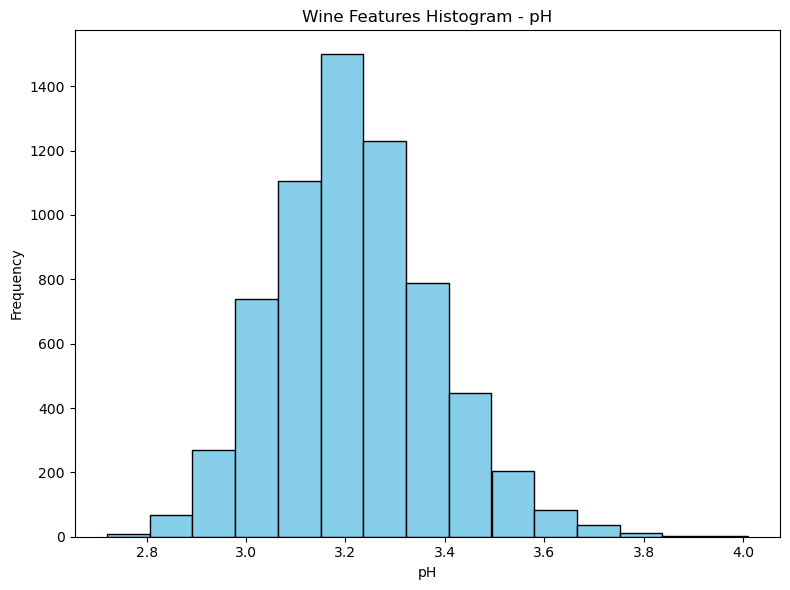

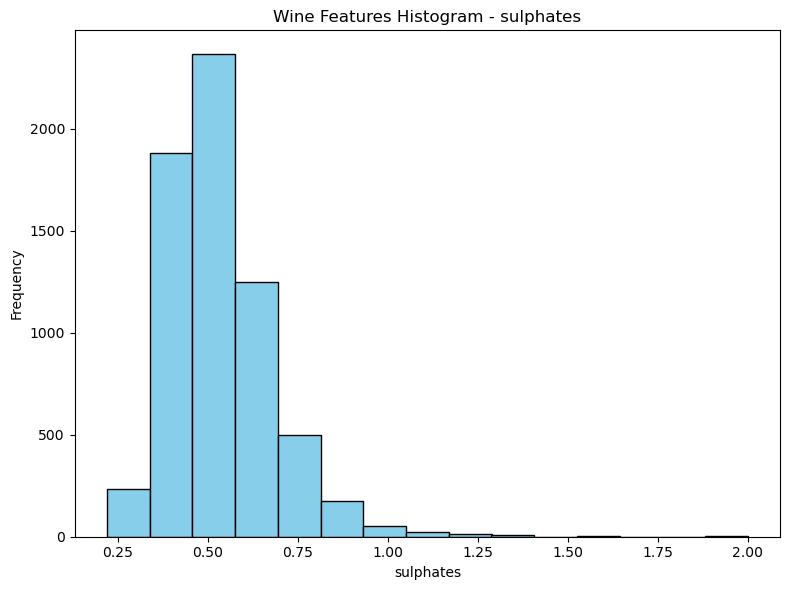

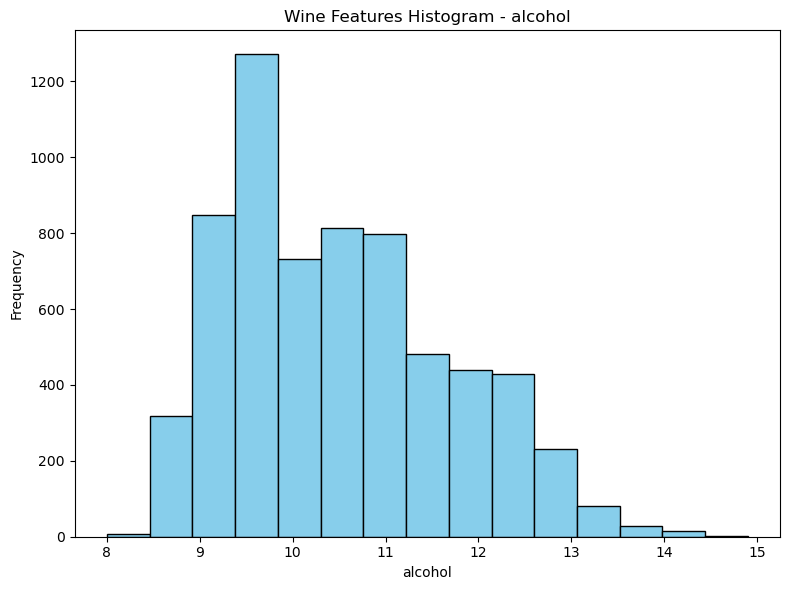

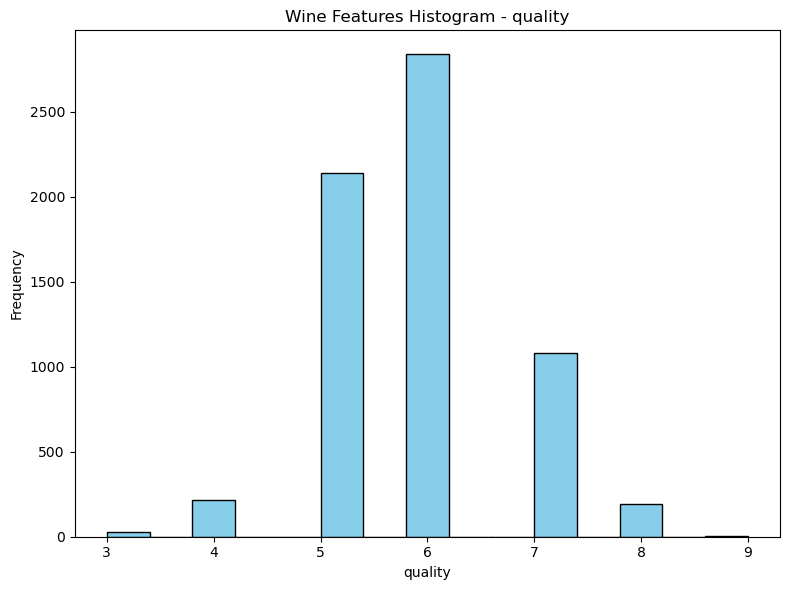

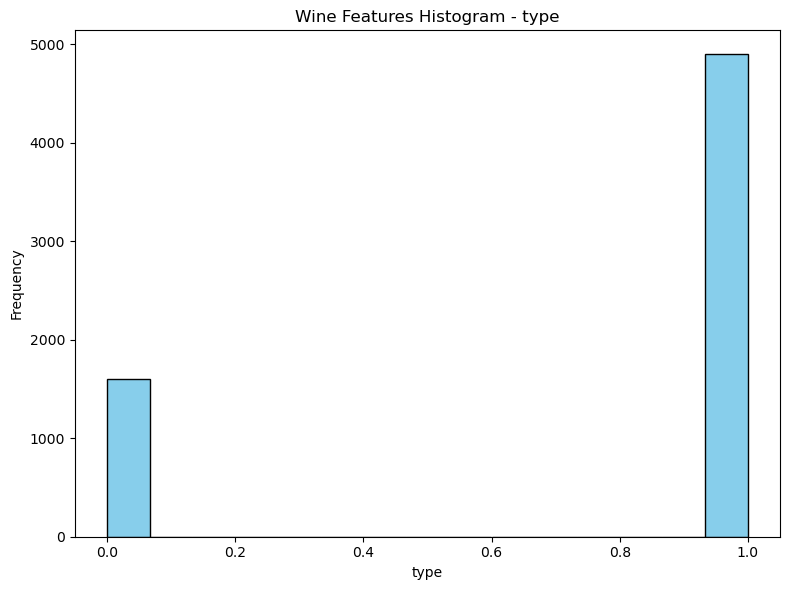

In [36]:
# Huge scaling, but otherwise i cant see the numbers
vs.histogram(wine_df, title='Wine Features Histogram')

In [37]:
#tells you if the distribution is asymmetric. 
#A value of 0 means perfectly symmetric, positive skewness means the right tail is longer, and negative skewness means the left tail is longer.
wine_df.skew()

fixed acidity           1.723290
volatile acidity        1.495097
citric acid             0.471731
residual sugar          1.435404
chlorides               5.399828
free sulfur dioxide     1.220066
total sulfur dioxide   -0.001177
density                 0.503602
pH                      0.386839
sulphates               1.797270
alcohol                 0.565718
quality                 0.189623
type                   -1.179095
dtype: float64

In [38]:
# tells you how heavy or light the tails of the distribution are compared to a normal distribution.
# A kurtosis greater than 3 indicates heavy tails (more outliers), while less than 3 means lighter tails.
wine_df.kurtosis()

fixed acidity            5.061161
volatile acidity         2.825372
citric acid              2.397239
residual sugar           4.359272
chlorides               50.898051
free sulfur dioxide      7.906238
total sulfur dioxide    -0.371664
density                  6.606067
pH                       0.367657
sulphates                8.653699
alcohol                 -0.531687
quality                  0.232322
type                    -0.609922
dtype: float64

### 7. Diagrams

In [40]:
df_red_clean = remove_duplicates(df_red)

In [41]:
df_white_clean = remove_duplicates(df_white)

In [42]:
wine_df_clean = remove_duplicates(wine_df)

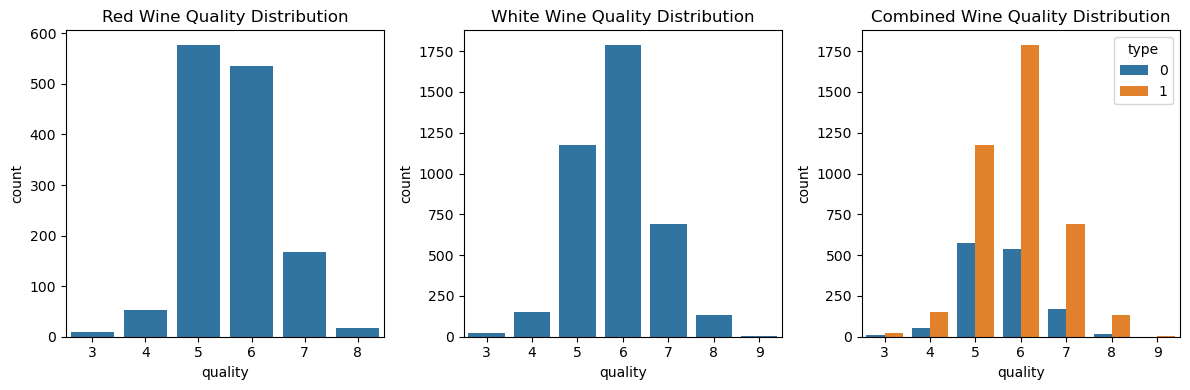

In [43]:
# Shows us a general overview of how many wines fall into each category of quality
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sbn.countplot(x='quality', data=df_red_clean)
plt.title('Red Wine Quality Distribution')

plt.subplot(1,3,2)
sbn.countplot(x='quality', data=df_white_clean)
plt.title('White Wine Quality Distribution')

plt.subplot(1,3,3)
sbn.countplot(x='quality', hue='type', data=wine_df_clean)
plt.title('Combined Wine Quality Distribution')

plt.tight_layout()
plt.show()

In [44]:
# Which type of wine has higher average quality?
mean_quality_red = wine_df_clean[wine_df_clean['type'] == 0]['quality'].mean()
mean_quality_white = wine_df_clean[wine_df_clean['type'] == 1]['quality'].mean()
difference = mean_quality_white - mean_quality_red
print(f"Red: {mean_quality_red:.2f}, White: {mean_quality_white:.2f}, Difference: {difference:.2f}")

Red: 5.62, White: 5.85, Difference: 0.23


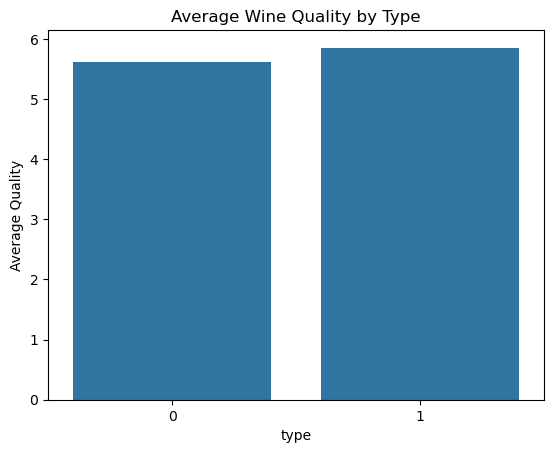

In [45]:
# Remember type 0 is Red and type 1 is White
avg_quality = wine_df_clean.groupby('type')['quality'].mean().reset_index()
sbn.barplot(x='type', y='quality', data=avg_quality)
plt.title('Average Wine Quality by Type')
plt.ylabel('Average Quality')
plt.show()

##### We now see that, once cleaned of missing values AND duplicates, white wines have a slightly higher average quality by 0.23

In [47]:
avg_alcohol = wine_df_clean.groupby('type')['alcohol'].mean()
print(avg_alcohol)

type
0    10.432315
1    10.589358
Name: alcohol, dtype: float64


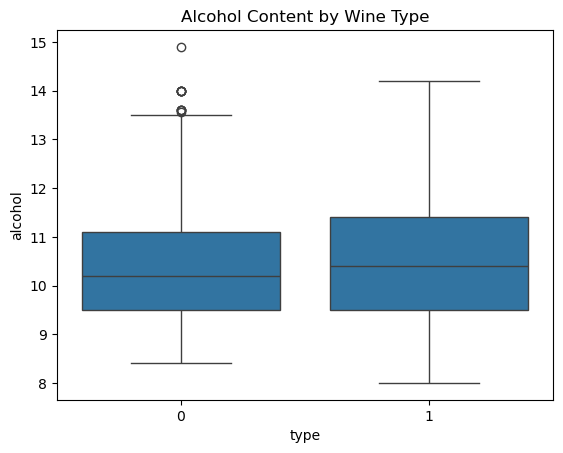

In [48]:
sbn.boxplot(x='type', y='alcohol', data=wine_df_clean)
plt.title('Alcohol Content by Wine Type')
plt.show()

##### We can see that white wine has a higher average alchohol content with 10.5893 vs red wine at 10.4323, with a few small outliers for red wine

In [129]:
upper_lim = wine_df_clean['alcohol'].quantile(.95)

In [131]:
wine_df_no_outliers = wine_df_clean[(wine_df_clean['alcohol'] < upper_lim)]

In [133]:
avg_alcohol_new = wine_df_no_outliers.groupby('type')['alcohol'].mean()
print(avg_alcohol_new)

type
0    10.315618
1    10.423469
Name: alcohol, dtype: float64


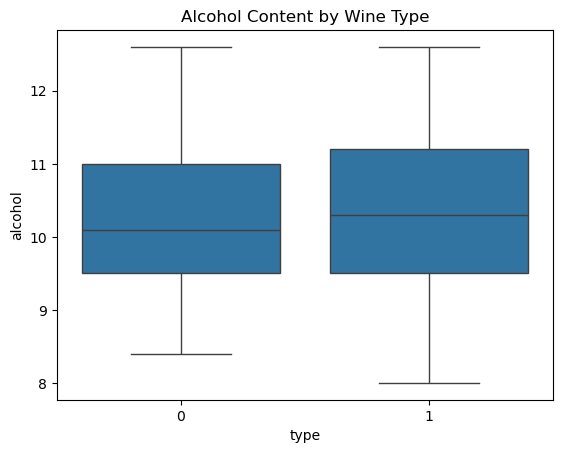

In [135]:
sbn.boxplot(x='type', y='alcohol', data=wine_df_no_outliers)
plt.title('Alcohol Content by Wine Type')
plt.show()

##### Now we see the results when we remove all outliers over the 95th percentile

In [54]:
avg_sugar = wine_df_clean.groupby('type')['residual sugar'].mean()
print(avg_sugar)

type
0    2.523400
1    5.914819
Name: residual sugar, dtype: float64


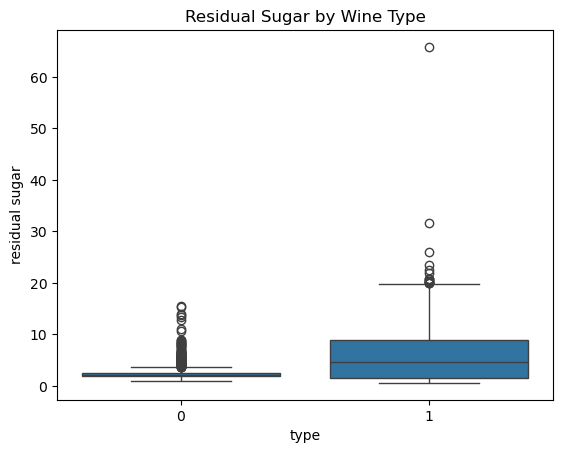

In [55]:
sbn.boxplot(x='type', y='residual sugar', data=wine_df_clean)
plt.title('Residual Sugar by Wine Type')
plt.show()

##### We see that white wine a significantly higher average residual sugar content at 5.9148 compared to red wine at 2.5234.
##### However, we also see from the boxplot that there is one massive outlier from the white wine datasheet

In [57]:
# Let's find this one obvious mega outlier
white_wine = wine_df_clean[wine_df_clean['type'] == 1].copy()
max_sugar_index = white_wine['residual sugar'].idxmax()

# Let's see the outlier itself
outlier_row = wine_df_clean.loc[max_sugar_index]
print("Outlier row with highest residual sugar (white wine):")
print(outlier_row)

Outlier row with highest residual sugar (white wine):
fixed acidity             7.80000
volatile acidity          0.96500
citric acid               0.60000
residual sugar           65.80000
chlorides                 0.07400
free sulfur dioxide       8.00000
total sulfur dioxide    160.00000
density                   1.03898
pH                        3.39000
sulphates                 0.69000
alcohol                  11.70000
quality                   6.00000
type                      1.00000
Name: 4380, dtype: float64


In [58]:
wine_df_outlier_gone = wine_df_clean.drop(index=max_sugar_index)

In [59]:
# Now let's try again
avg_sugar = wine_df_outlier_gone.groupby('type')['residual sugar'].mean()
print(avg_sugar)

type
0    2.523400
1    5.899697
Name: residual sugar, dtype: float64


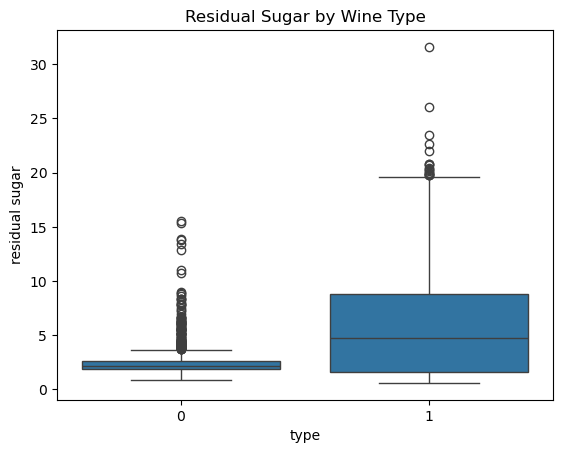

In [60]:
sbn.boxplot(x='type', y='residual sugar', data=wine_df_outlier_gone)
plt.title('Residual Sugar by Wine Type')
plt.show()

##### We see that white wine still has a significantly higher average residual sugar content at 5.8996 compared to red wine at 2.5234.
##### The biggest obvious outlier has been removed, yet other outliers remain from both types of wine (removing these should be discussed, yet it doesn't change that white wine is clearly with a higher sugar content overall). 

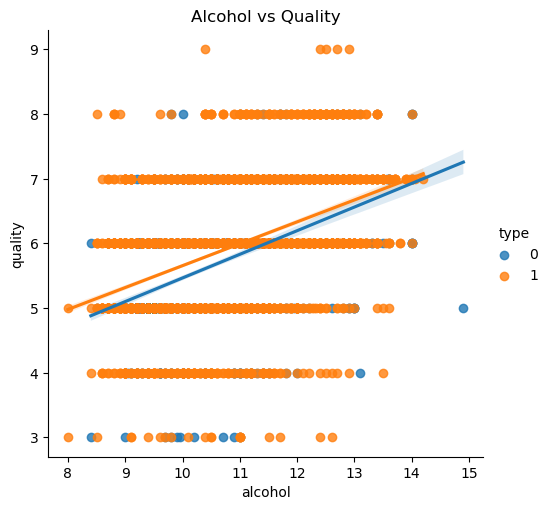

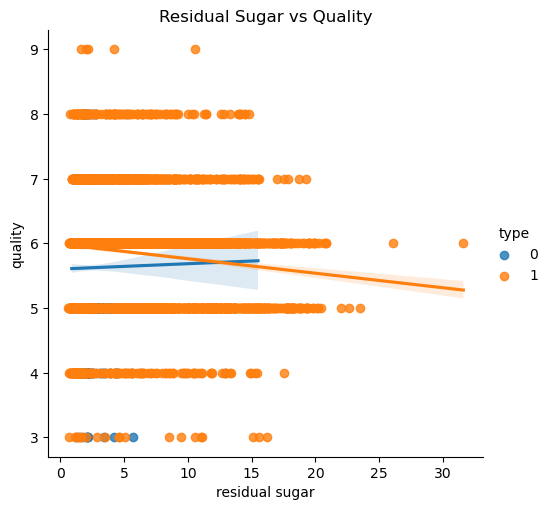

In [62]:
# Does the quantity of alcohol and residual sugar influence the quality of the wine?
sbn.lmplot(x='alcohol', y='quality', hue='type', data=wine_df_outlier_gone)
plt.title('Alcohol vs Quality')
plt.show()

sbn.lmplot(x='residual sugar', y='quality', hue='type', data=wine_df_outlier_gone)
plt.title('Residual Sugar vs Quality')
plt.show()

##### These scatterplots plot all the wines allowing us to see quality and compare these to either residual sugar or alchohol. The regression line indicates a trend and thus also gives an impression of whether there might be a positive or negative correlation

In [64]:
red_corr = wine_df_outlier_gone[wine_df_outlier_gone['type'] == 0][['alcohol', 'residual sugar', 'quality']].corr()
white_corr = wine_df_outlier_gone[wine_df_outlier_gone['type'] == 1][['alcohol', 'residual sugar', 'quality']].corr()
print("Red Wine Correlation:\n", red_corr)
print("White Wine Correlation:\n", white_corr)

Red Wine Correlation:
                  alcohol  residual sugar   quality
alcohol         1.000000        0.063281  0.480343
residual sugar  0.063281        1.000000  0.013640
quality         0.480343        0.013640  1.000000
White Wine Correlation:
                  alcohol  residual sugar   quality
alcohol         1.000000       -0.408962  0.462882
residual sugar -0.408962        1.000000 -0.120172
quality         0.462882       -0.120172  1.000000


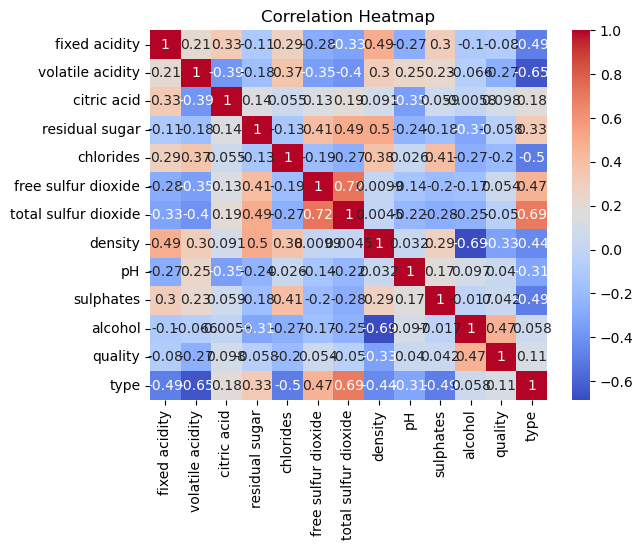

In [65]:
# A correlation heatmap for the entire dataframe containing both red and white wines
vs.correlation_heatmap(wine_df_outlier_gone)

##### We see that there's a positive correlation between alchohol content and quality for both red and white wine in our scatterplots, with it being only mildly more positive for red wine compared to white.
##### The correlation between residual sugar and quality however is not quite as apparent. White wine appears to have a slightly negative correlation while red wine looks barely positive BUT for red wine the correlation is uncertain enough that we can make a final conclusion based solely on diagrams.
##### However judging from the Pearson Correlation Matrices, knowing that 1 means a strong posititive correlation, -1 a strong negative and 0 no correlation, we can arrive at the following conclusion:

##### For red wine, with alchohol vs. quality correlation at 0.48, we have a moderate positive correlation - meaning more alchohol = better quality. Meanwhile with residual sugar vs. alchohol at only 0.014, there is pratically no correlation here.
##### For white wine, with alchohol vs. quality correlation at 0.46, we have a moderate positive correlation - meaning again more alchohol = better quality. However when it comes to residual sugar vs. quality at -0.12, we have a weak negative correlation - meaning quality drops slightly for white wines the more sugar is in it.

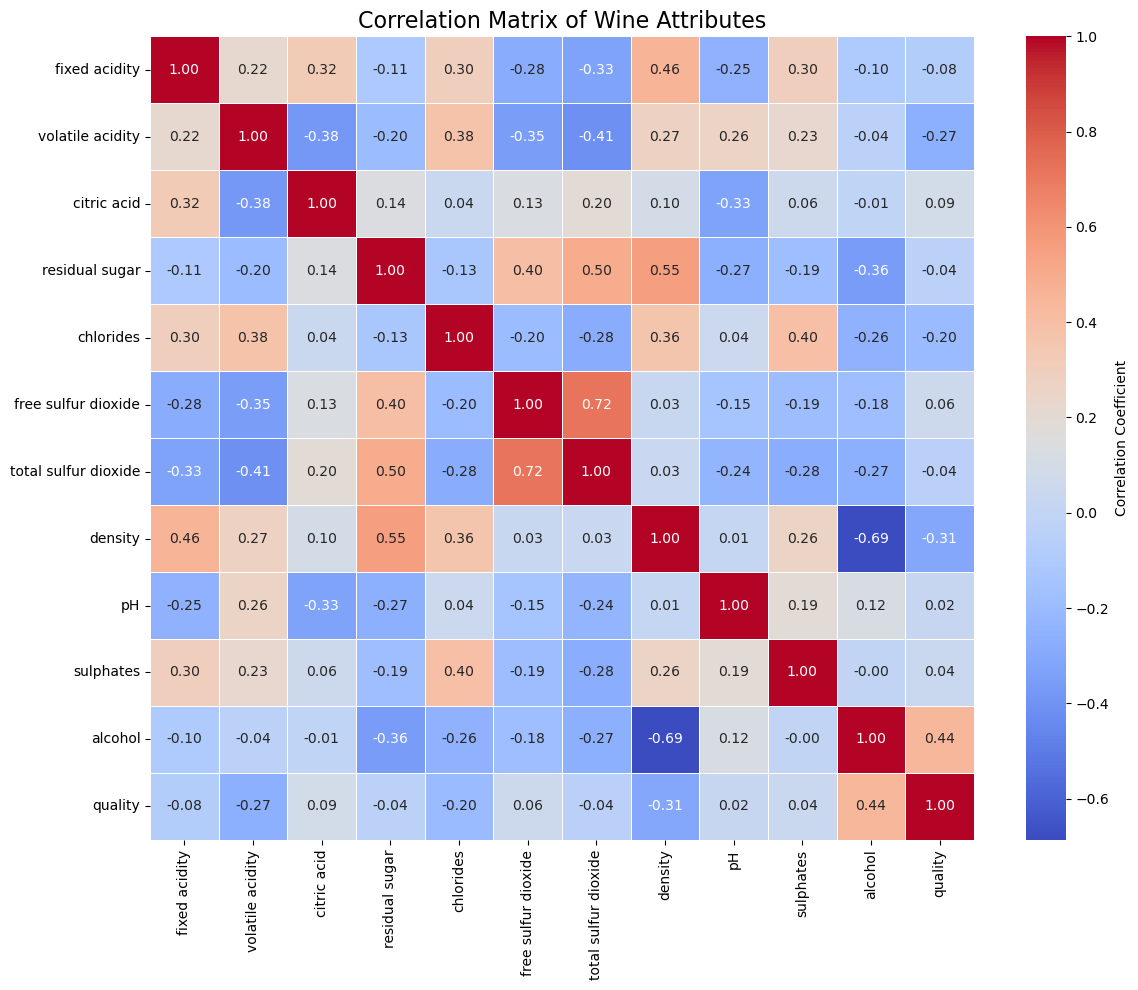

Wine attributes correlation with quality (from highest to lowest):
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64

The attribute with the biggest influence on wine quality is: alcohol (correlation: 0.444)
The attribute with the lowest influence on wine quality is: density (correlation: -0.306)

Highly correlated attributes (apart from wine quality):
free sulfur dioxide and total sulfur dioxide: 0.721
residual sugar and density: 0.553


In [68]:
# Task 10: Create a correlation matrix and a heatmap of all data and investigate it

# Calculate correlation matrix
correlation_matrix = wine_df.drop(columns=['type']).corr()

# Create a figure with appropriate size for the heatmap
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
heatmap = sbn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                     linewidths=0.5, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})

# Add title and adjust layout
plt.title('Correlation Matrix of Wine Attributes', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze correlation with quality (excluding quality itself)
quality_correlation = correlation_matrix['quality'].drop('quality').sort_values(ascending=False)
print("Wine attributes correlation with quality (from highest to lowest):")
print(quality_correlation)

# Find the attribute with the biggest influence on wine quality
max_attribute = quality_correlation.idxmax()
max_correlation = quality_correlation.max()
print(f"\nThe attribute with the biggest influence on wine quality is: {max_attribute} (correlation: {max_correlation:.3f})")

# attribute with the lowest influence on wine quality
min_attribute = quality_correlation.idxmin()
min_correlation = quality_correlation.min()
print(f"The attribute with the lowest influence on wine quality is: {min_attribute} (correlation: {min_correlation:.3f})")

# highly correlated attributes (apart from quality)
#  upper triangle 
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find pairs with high correlation (above 0.5, excluding quality)
high_corr_pairs = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        if upper_tri.loc[idx, col] > 0.5 and col != 'quality' and idx != 'quality':
            high_corr_pairs.append((idx, col, upper_tri.loc[idx, col]))

# Sort and display highly correlated pairs
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nHighly correlated attributes (apart from wine quality):")
for attr1, attr2, corr in high_corr_pairs:
    print(f"{attr1} and {attr2}: {corr:.3f}")

# If there are no highly correlated pairs
if not high_corr_pairs:
    print("No other attributes are highly correlated (correlation > 0.5)")